# Cartpole with Advantage Actor Critic



The actor critic algorithm consists of two networks (the actor and the critic) working together to solve a particular problem. At a high level, the Advantage Function calculates the agent’s TD Error or Prediction Error. The actor network chooses an action at each time step and the critic network evaluates the quality or the Q-value of a given input state. As the critic network learns which states are better or worse, the actor uses this information to teach the agent to seek out good states and avoid bad states.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers
from collections import deque
import random
from torch.autograd import Variable


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-5oib5oyb because the default path (/home/mihalis/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


First we create the environment:

In [2]:
env = gym.make('CartPole-v0') # Create environment

A state in this environment is four numbers describing the position of the cart along with the angle and speed of the pole.
There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [3]:
s = env.reset()
a = env.action_space.sample()
print(s.shape)
print('sample state:', s)
print('sample action:', a )

(4,)
sample state: [0.01478238 0.04553146 0.0486442  0.00790269]
sample action: 0


In [4]:
def show_replay():
    """
    Not-so-elegant way to display the MP4 file generated by the Monitor wrapper inside a notebook.
    The Monitor wrapper dumps the replay to a local file that we then display as a HTML video object.
    """
    import io
    import base64
    from IPython.display import HTML
    video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''
        <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
    .format(encoded.decode('ascii')))

### Defining the Actor Critic Model and the Advantage Function

In [4]:
class ActorCritic(nn.Module):
    """Actor critic network"""

    def __init__(self, n_inputs, n_hidden, n_actions, learning_rate):
        super(ActorCritic, self).__init__()
        
        # Common layers for the two heads:
        self.common_layers = nn.Sequential(
            nn.Linear(n_inputs, n_hidden),
            nn.ReLU(inplace=True),
        )
        # Actor and critic head of the model:
        self.actor = nn.Linear(n_hidden, n_actions)
        self.critic = nn.Linear(n_hidden,1)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        
        # Optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.common_layers(x)

        return F.softmax(self.actor(x),dim=1),self.critic(x)

    def loss(self,action_probabilities,values,returns):
        return self.actor_loss(action_probabilities,values,returns) + self.critic_loss(values,returns)
    
    def actor_loss(self,action_probabilities,values,returns):
        # The loss here defines the Advantage function
        advantage = returns - values
        action_logs = torch.log(action_probabilities)
        return -torch.mean(torch.mul(action_logs, advantage))
    
    def critic_loss(self,values,returns):
        return F.smooth_l1_loss(values,returns)

    def update(self, action_probabilities,values,returns):
        """Update the weights of the network given a training sample. """
        loss = self.loss(torch.Tensor(action_probabilities),torch.Tensor(values),torch.Tensor(returns))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.15)

        self.optimizer.step()
        return loss

In [5]:
# Compute the discounted rewards of the sequence
eps = np.finfo(np.float32).eps.item()
def compute_rewards(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    #standarize
    returns = ( returns - np.mean(returns) / np.std(returns)+eps)
    return returns

#### Defining hyperparameters
An example output of the agent can be seen below the next cell:  
The first part is the distribution of the actions, the second part is the State-Value function.

In [49]:
n_hidden = 256
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n
learning_rate = 0.001
# setup network

model = ActorCritic(n_inputs, n_hidden, n_outputs, learning_rate)

s = env.reset()
action_distr,state_value = model(torch.from_numpy(np.atleast_2d(s)).float())
print("Action distribution: "+ str(action_distr))
print("State-Value guess: "+str(state_value))

Action distribution: tensor([[0.4392, 0.5608]], grad_fn=<SoftmaxBackward>)
State-Value guess: tensor([[-0.1344]], grad_fn=<AddmmBackward>)


### Running a single episode and running a single training step in the following two functions

In [50]:
def run_episode(env,model):
    """
        Generate a training sequence by acting on the current model`s weights
    """
    rollout = []
    s = env.reset()
    done = False
    while not done:
        with torch.no_grad():
            a_dist,value = model(torch.from_numpy(np.atleast_2d(s)).float())
            action = torch.multinomial(a_dist, num_samples=1).squeeze().numpy()
            action_probs_t = a_dist.argmax().item()

            s1, reward, done, _ = env.step(action)
            rollout.append((s, action ,value, reward))
            s = s1
                
    return rollout

In [51]:
def training_step(env,model,gamma):
    
    # run a training episode based on the current model`s weights
    rollout = run_episode(env,model)
    
    # convert the episode sequence into a valid format.
    rollout = np.array(rollout)
    states = np.vstack(rollout[:,0])
    actions = np.vstack(rollout[:,1])
    values = np.array(rollout[:,2],dtype=float)
    rewards = np.array(rollout[:,3], dtype=float)
    states = np.array(states)
    
    # compute the discounted rewards
    discount_rewards = compute_rewards(rewards,gamma)
    
    # act again on the sequence states
    # note: state-values are already computed during the episode rollout
    policy,_ = model(torch.from_numpy(states).float())
    actions = policy.gather(1, torch.from_numpy(actions)).view(-1)
    
    # calulate and propagate the loss
    loss = model.update(actions,values,discount_rewards)
    
    # return the episode`s total reward
    return np.sum(rewards)

### Training the agent until a reward based goal is reached

In [52]:
# training settings
GOAL = 195

gamma = 0.99 # reward discount factor (gamma), 1.0 = no discount
val_freq = 300 # validation frequency


# train network
total_rewards = []

rewards = []
print('start training')
episodes=1
while True:
    
    model.optimizer.zero_grad()
    ep_reward = training_step(env,model,gamma)
    rewards.append(ep_reward)
    if (episodes % val_freq==0): 
        print('%5d mean training reward: %5.2f' % (episodes, np.mean(rewards[-val_freq:])))
        if np.mean(rewards[-50:]) >= GOAL:
            print("Goal reached!")
            break
    episodes+=1


start training


<ipython-input-51-3d0b4c9f6343>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rollout = np.array(rollout)


  300 mean training reward: 23.25
  600 mean training reward: 39.68
  900 mean training reward: 68.98
 1200 mean training reward: 91.11
 1500 mean training reward: 134.54
Goal reached!


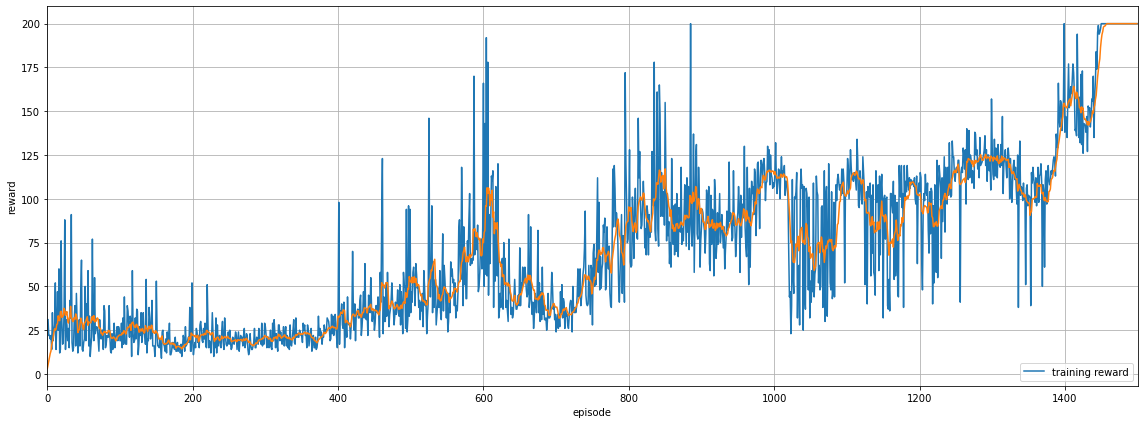

In [53]:
# plot results
total_rewards = np.array(rewards)

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(111)
plt.plot(range(1, len(rewards)+1), rewards, label='training reward')
plt.plot(moving_average(rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(rewards)))
plt.legend(loc=4); plt.grid()

plt.tight_layout(); plt.show()

Now let's review the solution!

In [56]:
env = wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
s = env.reset()

for _ in range(500):
    env.render()
    a,_ = model(torch.from_numpy(np.atleast_2d(s)).float())
    a = a.argmax().item()
    s, r, done, _ = env.step(a)
    if done: break
    
env.close()
